In [1]:
# jbk28@cam.ac.uk 13/01/17
from __future__ import division, print_function, unicode_literals # if Python 2.x is used
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Numerical differential equations

In the simplest methods for solving differential equations numerically, one goes back to the definition of the differential operator: `lim dx->0 (f(t + dx) - f(t))/dx` and simply take `dx` small, but finite, which will approximate the true derivative.
We start by understanding this.

### Numerical differentiation
We start by defining a few functions for which we know their analytical derivative.

In [2]:
dx = 0.3
x = np.arange(0, 10, dx) # returns [0, dx, 2dx, 3dx, 4dx, 5dx, ...]
print(x)
f1 = np.sin(x)
f2 = x**2/100
f3 = np.log(1+x)-1
fs = [f1, f2, f3]

[ 0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4  2.7  3.   3.3  3.6  3.9  4.2
  4.5  4.8  5.1  5.4  5.7  6.   6.3  6.6  6.9  7.2  7.5  7.8  8.1  8.4  8.7
  9.   9.3  9.6  9.9]


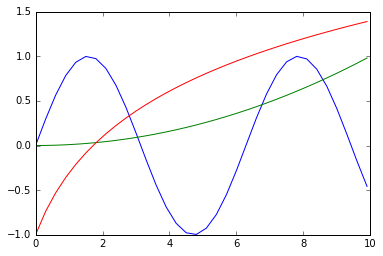

In [3]:
for i in range(3): plt.plot(x, fs[i])

In [4]:
df1 = np.cos(x)
df2 = x/50
df3 = 1/(1+x)
dfs = [df1, df2, df3]

Now let us see if we can calculate these derivatives numerically.

In [5]:
def derivative(f, dx):
    return (f[1:] - f[:-1])/dx # returned function is one value shorter than input f
ndfs = [derivative(f, dx) for f in fs]

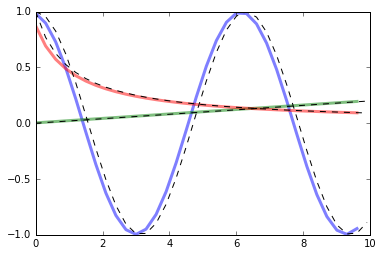

In [6]:
for i in range(3): plt.plot(x[:-1], ndfs[i], lw=3, alpha=0.5)
for i in range(3): plt.plot(x, dfs[i], '--k')
plt.show()

That worked pretty well, but we can do even better by using central differences for estimating the deriavtive.

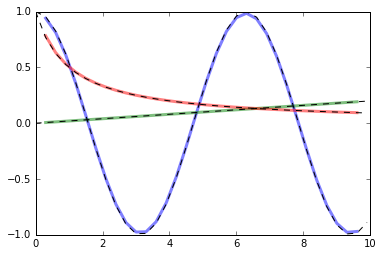

In [7]:
def central_derivative(f, dx):
    return (f[2:] - f[:-2])/(2*dx) # returned function is two values shorter than input f
ndfs = [central_derivative(f, dx) for f in fs]
for i in range(3): plt.plot(x[1:-1], ndfs[i], lw=3, alpha=0.5)
for i in range(3): plt.plot(x, dfs[i], '--k')
plt.show()

The error is order `dx` for left/right derivatives, but only `dx^2` for central derivatives.

## Initial Value Problems
We now turn to simple ODE's. Consider the damped harmonic oscillator equation
```
x''(t) = - k x(t) - d x'(t)
```
which we can write as
```
x'(t) = v(t)
v'(t) = -k x(t) - d v(t).
```
We want to solve this with initial conditions `x(0) = x0, v(0) = v0`.

In [8]:
def analytical_solution(t, k, d, x0, v0):
    d += 0j # Exploiting complex numbers for one general solution
    return np.real((np.exp(-((d*t)/2))*(np.sqrt(d**2-4*k)*x0*np.cosh(1/2*np.sqrt(d**2-4*k)*t)+(2*v0+d* \
           x0)*np.sinh(1/2*np.sqrt(d**2-4*k)*t)))/np.sqrt(d**2-4*k))

In [9]:
dt = 0.02
t = np.arange(0,25,dt)
k = 5; d = 0.3; x0 = 0; v0 = 1

In [10]:
x = np.zeros_like(t)
v = np.zeros_like(t)
x[0] = x0; v[0] = v0

In [11]:
for i in range(len(t)-1): # Step through time with step size dt
    v[i + 1] = v[i] + (-k * x[i] - d * v[i]) * dt
    x[i + 1] = x[i] + v[i+1] * dt # v[i+1] makes a big stability difference!

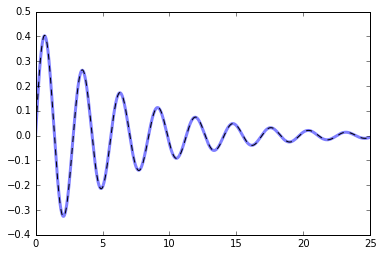

In [12]:
plt.plot(t, x, lw=3, alpha=0.5)
plt.plot(t, analytical_solution(t, k, d, x0, v0), '--k')
plt.show()

### Exercise
(Skip this exercise if you feel confident it's easy)

Change the above code to solve 
```
x''(t) = - k sin(x(t))
```

If time permits: lookup documentation for `scipy.integrate.odeint` and use that to solve the above equation. This will be much more efficient. But do other exercises first.

## Boundary Value Problems
Now we want to solve the equation
```
y''(x) = y(x)
y(0) = y0
y(1) = y1
```
We can no longer iterate forwards from a given start point as we could before, where both `x(0)` and `x'(0)` were known.
There are many methods to solve systems as the above (shootings methods, relaxation methods, etc), but we will use the simplest direct method here. Again we base it on finite differences.

In [13]:
dx = 0.01
x = np.arange(0, 1, dx)
n = len(x)
y0 = 1
y1 = 10

Imagine that we had calculated `y`. It would be some array:

In [14]:
y = x**4 # not correct

How would we calculate the vector `y''`? In particular, can we find a matrix `L` such that `y'' = L y`?

Double derivatives can be estimated by finite differences as (see https://en.wikipedia.org/wiki/Finite_difference_coefficient)
```
y''(x) = (y(x + dx) + y(x - dx) - 2 y(x))/dx^2
```
Let's build a matrix based on that:

In [15]:
L = np.diag(np.ones(n - 1), 1) + np.diag(np.ones(n - 1), -1) - 2 * np.diag(np.ones(n))
print(L)
L = L/dx**2

[[-2.  1.  0. ...,  0.  0.  0.]
 [ 1. -2.  1. ...,  0.  0.  0.]
 [ 0.  1. -2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ..., -2.  1.  0.]
 [ 0.  0.  0. ...,  1. -2.  1.]
 [ 0.  0.  0. ...,  0.  1. -2.]]


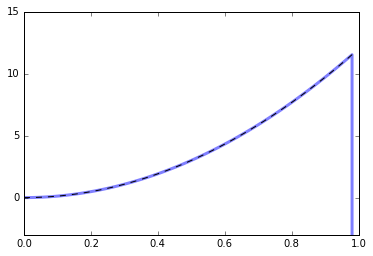

In [16]:
ypp = np.dot(L, y) # matrix product L y
plt.plot(x, ypp, lw=3, alpha=0.5)
plt.plot(x, 4*3*x**2, '--k')
plt.axis([0, 1, -3, 15])
plt.show()

All looks good, expect the endpoints. This was expected. This is why we have boundary conditions.

We can write our equation `y''(x) = y(x)` as `y''(x) - y(x) = 0` and by introducing the double derivative operator `L` and the identity operator `I`, we could also write it as
```
(L - I) y = 0
```
The idenitity operator for vectors is of course just the idenitity matrix

In [17]:
I = np.eye(n)
A = L - I

Where `A` is defining the full problem.
The problem is still not well-defined as we need to somehow implement our boundary conditions.
Let's do it, and explain afterwards:

In [18]:
A[0, :] = 0
A[0, 0] = 1
A[-1, :] = 0
A[-1, -1] = 1
b = np.zeros(n)
b[0] = y0
b[-1] = y1

np.set_printoptions(suppress=True)
print(np.round(A))
print('* y == ')
print(b)

[[     1.      0.      0. ...,      0.      0.      0.]
 [ 10000. -20001.  10000. ...,      0.      0.      0.]
 [     0.  10000. -20001. ...,      0.      0.      0.]
 ..., 
 [     0.      0.      0. ..., -20001.  10000.      0.]
 [     0.      0.      0. ...,  10000. -20001.  10000.]
 [     0.      0.      0. ...,      0.      0.      1.]]
* y == 
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.]


The first row extracts y[0] and the equation then sets it equal to y0(=1) and the last row extracts y[-1] and sets it equal to y1(=10).
All other lines sets double derivatives equal to zero.

Solving the above linear system of equations is easy.
Numpy linear algebra module can do it for us:

In [19]:
from numpy.linalg import solve
y = solve(A, b)

In [20]:
analytical = (np.exp(-x)*(np.exp(1)*(np.exp(1)*y0-y1)+np.exp(2*x)*(-y0+np.exp(1)*y1)))/(-1+np.exp(2))

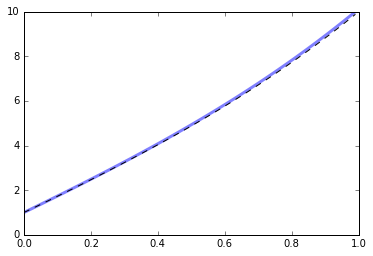

In [21]:
plt.plot(x, y, lw=3, alpha=0.5)
plt.plot(x, analytical, '--k')
plt.show()

It is great for testing one's code that we can compare to analytical solutions, but of course the strength of numerical methods is that we can solve equations that we do not have analytical solutions for.

### Exercise
Solve
```
y''(x) = y'(x) + sin(x)*exp(x)
y(-pi) = 0
y(pi) = 1
```

The analytical solution is given below.

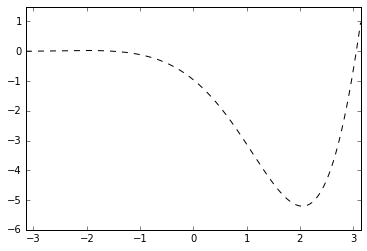

In [22]:
dx = 0.01
x = np.arange(-np.pi, np.pi, dx)
y = 1/4*np.exp(-np.pi)/np.sinh(np.pi)*(-2+np.exp(x)*(1+2*np.exp(np.pi)+np.cos(x)+ \
        np.sin(x)-np.exp(2*(np.pi))*(1+np.cos(x)+np.sin(x))))
plt.plot(x, y, '--k')
plt.axis([-np.pi, np.pi, -6, 1.5])
plt.show()

### Extra exercise
What about Neumann boundary conditions? Try writing a solver for
```
y''(x) = y'(x) + sin(x)*exp(x)
y(-pi) = 1
y'(pi) = 0
```
As a check, the correct solution has `y(0) = -0.956331`.

## Partial differential equations
Just as PDE's are harder to solve than ODE's, so are PDE's much harder to implement numerically.
Most courses tend to avoid these and say they "generalise from ODE's", which I would argue is not true.
But this being a maths department, PDE solving might relevant, so we will cover this area. But focus on simple methods.

### 3D functions
We start by showing how to plot
```
u(x,y) = exp(x) sin(y)
```

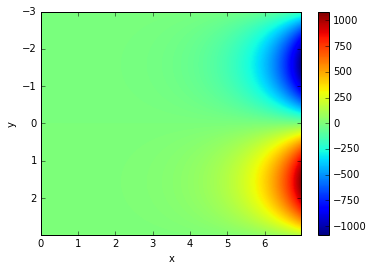

In [23]:
dx = 0.01
x = np.arange(0, 7, dx)
y = np.arange(-3, 3, dx)
X, Y = np.meshgrid(x, y)
U = np.exp(X) * np.sin(Y)

plt.imshow(U, extent=(min(x), max(x), max(y), min(y)))
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In the above `np.meshgrid` has made the 2D arrays `X,Y`:

In [24]:
print(X.shape, Y.shape, U.shape)
print(X)

(600, 700) (600, 700) (600, 700)
[[ 0.    0.01  0.02 ...,  6.97  6.98  6.99]
 [ 0.    0.01  0.02 ...,  6.97  6.98  6.99]
 [ 0.    0.01  0.02 ...,  6.97  6.98  6.99]
 ..., 
 [ 0.    0.01  0.02 ...,  6.97  6.98  6.99]
 [ 0.    0.01  0.02 ...,  6.97  6.98  6.99]
 [ 0.    0.01  0.02 ...,  6.97  6.98  6.99]]


### Example problem
Let us solve the steady state heat (Laplace) equation with known temperature boundary conditions
```
Laplacian u(x, y) = 0
u(x, 0) = 1
u(0, y) = 1 - y
u(x, 1) = 0
y(1, y) = 0
```

We start by defining our domain:

In [25]:
dx = 0.02
x = np.arange(0, 1 + dx, dx)
m = len(x)
print(x[0], x[-1])
X, Y = np.meshgrid(x, x)
shape = X.shape

0.0 1.0


We wish to solve for `U`, but currently `U`, like `X` and `Y`, would be a matrix. Linear systems tend to work on vectors, so we should formulate our system such that we can solve for a vector.
For this purpose we define functions that take us from vector to matrix and vice versa.

In [26]:
def to_vector(mat):
    return np.ravel(mat)
def to_matrix(vec):
    return np.reshape(vec, shape)

In [27]:
print(X.shape, '=>', to_vector(X).shape)
print((X == to_matrix(to_vector(X))).all())
print((Y == to_matrix(to_vector(Y))).all())

(51, 51) => (2601,)
True
True


So we define 1D arrays of our coordinates:

In [28]:
x = to_vector(X)
y = to_vector(Y)
n = len(x)

The discrete Laplacian looks like this:
```
0   1   0
1  -4   1
0   1   0
```
divided by `dx^2`

There are smart ways to make this, but it depends on how you form the vectors.
We should not dwelve too long at the details of how we've done it here (ravel, reshape), but instead we will build the Laplacian in a silly way using a loop. This way will work no matter how scrambled the coordinates are in the vector.

In [29]:
L = np.zeros((n, n))
for i in range(n):
    L[i,i] = -4
    
    j = np.argmin( (x[i] + dx - x)**2 + (y[i] - y)**2 ) # Find index j in vectors for point (x[i]+dx, y[i])
    if i!=j: L[i,j] = 1 # If i==j, we are at the boundary of the domain
    
    j = np.argmin( (x[i] - dx - x)**2 + (y[i] - y)**2 ) # Find index j in vectors for point (x[i]-dx, y[i])
    if i!=j: L[i,j] = 1
    
    j = np.argmin( (x[i] - x)**2 + (y[i] + dx - y)**2 ) # Find index j in vectors for point (x[i], y[i]+dx)
    if i!=j: L[i,j] = 1
    
    j = np.argmin( (x[i] - x)**2 + (y[i] - dx - y)**2 ) # Find index j in vectors for point (x[i], y[i]-dx)
    if i!=j: L[i,j] = 1
print(L)
L = L/dx**2

[[-4.  1.  0. ...,  0.  0.  0.]
 [ 1. -4.  1. ...,  0.  0.  0.]
 [ 0.  1. -4. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ..., -4.  1.  0.]
 [ 0.  0.  0. ...,  1. -4.  1.]
 [ 0.  0.  0. ...,  0.  1. -4.]]


As mentioned, this can be done much more efficiently (and without using loops).
But this requires that one understands how the reorganisation to vectors work.
Anyway, just to show how one could do it:

In [30]:
L_quick = -4 * np.eye(n) + np.diag(np.ones(n-m), m) + np.diag(np.ones(n-m), -m)
a = np.ones(n-1); a[(m-1)::m] = 0
L_quick += np.diag(a,1) + np.diag(a,-1)
L_quick = L_quick/dx**2

print( (L == L_quick).all() )

True


Now we implement the boundary conditions:

In [31]:
b = np.zeros(n)
for i in range(n):
    if (x[i]==0 or x[i]==1 or y[i]==0 or y[i]==1): # For any boundary point
        L[i, :] = 0
        L[i, i] = 1
    
    # BC points that are not equal to zero:
    if x[i] == 0:
        b[i] = 1 - y[i]
    elif y[i] == 0:
        b[i] = 1

And lastly, we solve:

In [32]:
from scipy.linalg import solve
u = solve(L, b)

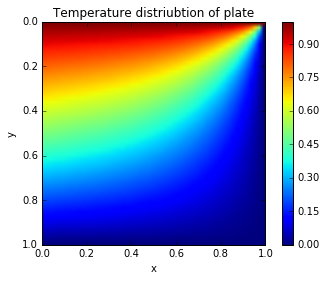

In [33]:
U = to_matrix(u)
plt.imshow(U, extent=(min(x), max(x), max(y), min(y)))
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Temperature distriubtion of plate')
plt.show()

### Exercise
Heat equation with heat source. Solve:
```
Laplacian u(x, y) = exp(-2*((x-0.5)^2+(y-0.5)^2))
u(x, 0) = 1
u(0, y) = 1 - y
u(x, 1) = 0
y(1, y) = 0
```

### Extra exercise (harder)
Heat equation with flow. Solve:
```
Laplacian u(x, y) = v(x, y) grad u(x, y)
u(x, 0) = 1
u(0, y) = 1 - y
u(x, 1) = 0
y(1, y) = 0
```
where `v(x, y)` is some incompressible flow, e.g. solid-body rotation:
```
v_x = -(y-0.5)
v_y = (x-0.5)
```

## Extra Technical Details

### Time-stepping
When we discretise an equation, e.g.
```
y'(t) = -k y(t)
```
we get in Python
```
y[i+1] = y[i] - k * y[i] * dt
```
This is called explicit time-stepping and can be unstable (especially if `k` is very big).

Instead we could have written
```
y[i+1] = y[i] - k * y[i+1] * dt
```
Of course, in its current form, this makes no sense. We cannot use `y[i+1]` until we calculate it.
But we could solve the above equation and instead write
```
y[i+1] = y[i]/(1 + k * dt)
```
This is called implicit time-stepping and is typically much more stable and often required to have any progress.
The above example was simple, for PDE's implicit time-stepping typically requires solving a matrix equation.


### Sparse matrices
Our operator matrices `A` typically contain a lot of zeros.
For big problems, the matrices become so big that they cannot be contained in memory.
For such problems we don't want to explicitly store the zeros. This is purpose of sparse matrices. They only store non-zero entries.
See `scipy.sparse`. There are also super fast solvers for sparse matrices. Simple ones can be found in `scipy.sparse.linalg`.

### Grids
For the PDE examples we have worked only on rectangular grids.
On these grids finite difference methods work well. It is also easy to add periodic boundary conditions.
But many problems are not on rectangular grids, what then?
That's a big question that is beyond on the scope of this course for sure.
But you should have at least heard of the "finite element method".
This is one approach to solving PDEs on complicated domains.

### Non-linearities
We have only looked at linear equations.
Non-linear equations cannot be solved in one go by a matrix equation, but its solution must be iterated towards.
Imagine you wanted to solve
```
Laplacian u(x, y) = u(x,y)^2
```

You can make an initial guess `u_0`, and then calculate a better guess by solving

```
Laplacian u_1(x, y) = u_1(x,y) u_0(x,y)
```

If you keep iterating this, you should end up at the solution.
There are many methods, however. This was just to show one simple approach (which won't always work).